# AB_fit_simulated 

Here I want to fit the simulated light curves, sampled at timestamps corresponding to combined light curves,  i.e.  SDSS(r), SDSS(r)+PS1(gri), etc.  

We make sure that to each simulated light curve we add the Gaussian noise corresponding to each epochal photometric uncertainty  ( so that the noise matches the claimed error).

Otherwise, if I were only to simulate a perfect DRW signal, and say that there is some photometric uncertainty and yet not add any noise, this would confuse the fitting code about what is the source of variability  - it would be deceived into thinkinig that the errors contribute more to the observed variability than they do (if no noise is added, the errors do not contribute at all, which is not what really happens). 

In reality, a perfect DRW signal is on top of the variability originating from photometric noise, described by the photometric uncertainty (error). Even a constant signal would have some variability due to the photometric uncertainty, which is different for each point (magnitude dependent, etc. )



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import unique
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

#outDir = '../data_products/SDSS-PTF-CRTS-PS1_/'
#done_lcs = os.listdir(outDir)
#done_lcs.remove('.DS_Store')

In [2]:
# Read the summary table with median SDSS, PS1, PTF, CRTS  band magnitude  per object ... 
summary = Table.read('summary_combined_lc_info.txt', format='ascii') 

In [3]:
# pick the LCs with best frequency ...
m1 = summary['SDSS_rN'] > np.percentile(summary['SDSS_rN'],80)
m2 = summary['PS1_rN'] > np.percentile(summary['PS1_rN'],80)
summary[m1*m2]

<Table length=60>
   lcname   SDSS_uN SDSS_medianuerr ... CRTS_wN CRTS_medianwerr CRTS_medianwmag
   str11    float64     float64     ... float64     float64         float64    
----------- ------- --------------- ... ------- --------------- ---------------
  10579.txt   113.0           0.038 ...   212.0            0.08          18.465
 177186.txt   112.0           0.036 ...   247.0            0.17           18.92
 948053.txt    66.0          0.1505 ...   125.0            0.28           20.23
3950223.txt   114.0          0.0475 ...   406.0            0.15          19.125
1364850.txt    79.0           0.116 ...    95.0            0.31            20.1
 230288.txt    73.0           0.082 ...   170.0            0.21           20.12
 129563.txt    97.0           0.059 ...   136.0            0.13           19.75
3959404.txt   107.0           0.024 ...   346.0            0.13          18.725
2447561.txt   101.0           0.025 ...   413.0             0.1           17.71
4231331.txt   103.0           0.062 ...    61.0            0.22           19.45
        ...     ...             ... ...     ...             ...             ...
4074742.txt   114.0           0.075 ...   354.0            0.19           19.34
   5429.txt   101.0           0.037 ...   178.0            0.21           19.37
1468964.txt    95.0           0.098 ...   138.0            0.21          19.305
3913101.txt   108.0          0.1105 ...   287.0            0.16           20.04
1827768.txt   110.0           0.079 ...   276.0            0.19           19.12
1440408.txt   109.0           0.046 ...   328.0            0.18           19.05
3953453.txt   110.0          0.0325 ...   196.0            0.15           18.52
3876572.txt   106.0            0.07 ...   192.0            0.12           19.39
3925117.txt   105.0           1.171 ...    34.0            0.32          20.195
 932097.txt    66.0           0.103 ...   211.0            0.23           19.74

In [58]:
def fit_celerite(time, mag, magerr,axis ):
    ''' Quick convenience function to find the MAP estimate 
    with Celerite , using some standard setup,
    and plot the prediction with "error snake"
    of the mean +/-  stdev  given the data 
    
    Input: 
    -------
    time, mag,  magerr : the light curve for which to 
          find the DRW fitted parameters 
    ax : axis on which to plot the predictions 
    
    Returns : 
    --------
    None 
    
    '''
    # Fit the true combined LC 
    prior='Jeff1'
    sig_lims = [0.01,1]
    tau_lims = [1,10000]
    sigma_in = 0.2 ;  tau_in = 575 # starting params for the fit 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(time,mag,magerr,
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=True)

    # plot the prediction conditioned on the observed data 
    x = np.linspace(min(time), max(time), 5000)
    pred_mean, pred_var = gp.predict(mag, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    color = "#ff7f0e"
    axis.plot(x, pred_mean, color=color)
    axis.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, 
                     color=color, alpha=0.3,
                     )

60

In [79]:
0.0001 * 86400

8.64

In [81]:
for i in range(len(lcs)):
    lcname = lcs[i]
    #print(lcname)
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    n = len(np.unique(lc_comb['mjd']))  - len(lc_comb['mjd'])
    if abs(n) > 0: 
        print(i, lcname , 'diff=',n)
        mjd, count = np.unique(lc_comb['mjd'], return_counts=True)

        # pick those timestamps that are not unique and see why ... 
        print(lc_comb[np.in1d(lc_comb['mjd'], mjd[count>1])])

4 1364850.txt diff= -6
     mag      magerr     mjd     originBand originSurvey
------------- ------ ----------- ---------- ------------
20.6631205117   0.42 53670.15527          w         crts
20.0831205117   0.31 53670.15527          w         crts
20.6331205117    0.4 53989.18315          w         crts
19.4631205117   0.21 53989.18315          w         crts
20.9731205117   0.51 55094.30601          w         crts
20.9731205117   0.51 55094.30601          w         crts
21.1131205117   0.54 55356.43056          w         crts
20.6731205117   0.42 55356.43056          w         crts
21.1431205117   0.57 56191.26357          w         crts
19.9931205117    0.3 56191.26357          w         crts
19.9931205117   0.31  56453.4461          w         crts
20.6131205117   0.44  56453.4461          w         crts


In [97]:
for time in mjd[count>1] :
    old_time = lc_comb['mjd'][lc_comb['mjd'] == time][0]
    new_time = old_time + 100.001
    lc_comb['mjd'][lc_comb['mjd'] == time][0] = new_time

In [98]:
lc_comb[np.in1d(lc_comb['mjd'], mjd[count>1])]

<Table length=12>
     mag       magerr     mjd     originBand originSurvey
   float64    float64   float64      str1        str4    
------------- ------- ----------- ---------- ------------
20.6631205117    0.42 53670.15527          w         crts
20.0831205117    0.31 53670.15527          w         crts
20.6331205117     0.4 53989.18315          w         crts
19.4631205117    0.21 53989.18315          w         crts
20.9731205117    0.51 55094.30601          w         crts
20.9731205117    0.51 55094.30601          w         crts
21.1131205117    0.54 55356.43056          w         crts
20.6731205117    0.42 55356.43056          w         crts
21.1431205117    0.57 56191.26357          w         crts
19.9931205117     0.3 56191.26357          w         crts
19.9931205117    0.31  56453.4461          w         crts
20.6131205117    0.44  56453.4461          w         crts

## Illustrate fitting .... 

[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.147071967633 tau_fit 53.7929383277
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.0969264990794 tau_fit 203.904811649
Saved as  ../data_products/Combined_LC_figs/10579_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.124525358947 tau_fit 51.4841324065
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.11357969275 tau_fit 409.403431296
Saved as  ../data_products/Combined_LC_figs/177186_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.266955829382 tau_fit 21.4809853208
[-3.21887582 -6.35437004]
si

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Saved as  ../data_products/Combined_LC_figs/230288_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.094017603521 tau_fit 15.9289874617
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.106393336314 tau_fit 288.525930747
Saved as  ../data_products/Combined_LC_figs/129563_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.244156225708 tau_fit 1.0
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.122280981929 tau_fit 357.788635112
Saved as  ../data_products/Combined_LC_figs/3959404_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.105770282927

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.102807143091 tau_fit 290.884759196
Saved as  ../data_products/Combined_LC_figs/2816673_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 1.0 tau_fit 1.0
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.0991259935993 tau_fit 194.641456357
Saved as  ../data_products/Combined_LC_figs/3900099_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.232096403546 tau_fit 154.424631604
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.103701792264 tau_fit 296.437192682
Saved as  ../data_products/Combined_LC_figs/4

[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.188810423348 tau_fit 89.1966475647
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.117976907821 tau_fit 365.836447023
Saved as  ../data_products/Combined_LC_figs/1140411_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.2 tau_fit 575.0
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.2 tau_fit 575.0
Saved as  ../data_products/Combined_LC_figs/96715_fit.png
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000]
[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]
sigma_fit 0.168472763609 tau_fit 137.390207371
[-3.21887582 -6.35437004]
sig_lims: [0.01, 1] tau_lims: [1, 10000

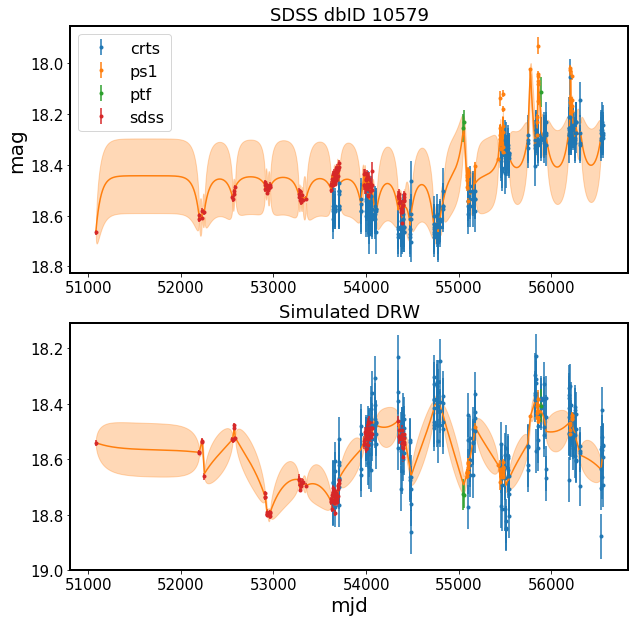

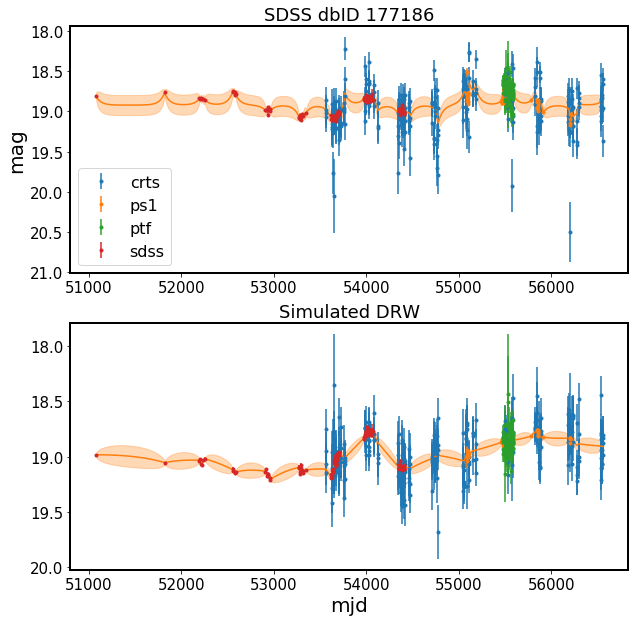

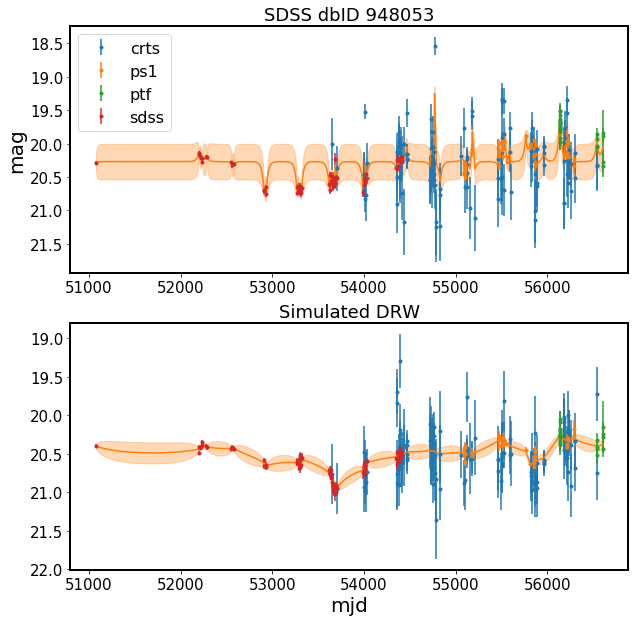

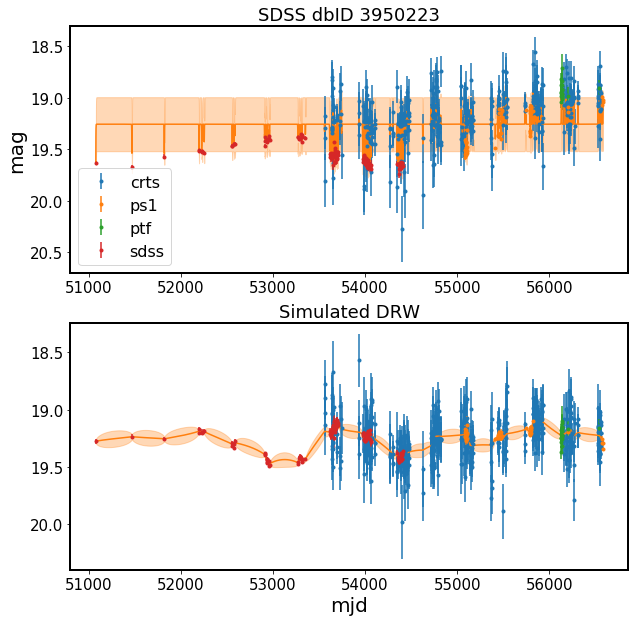

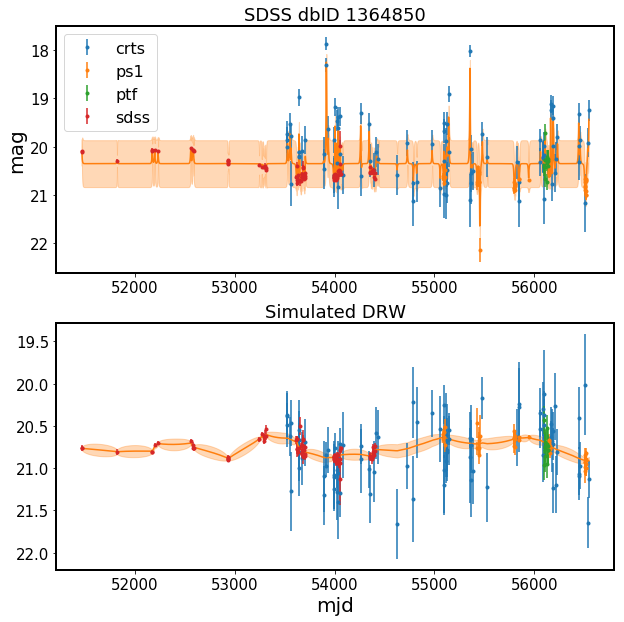

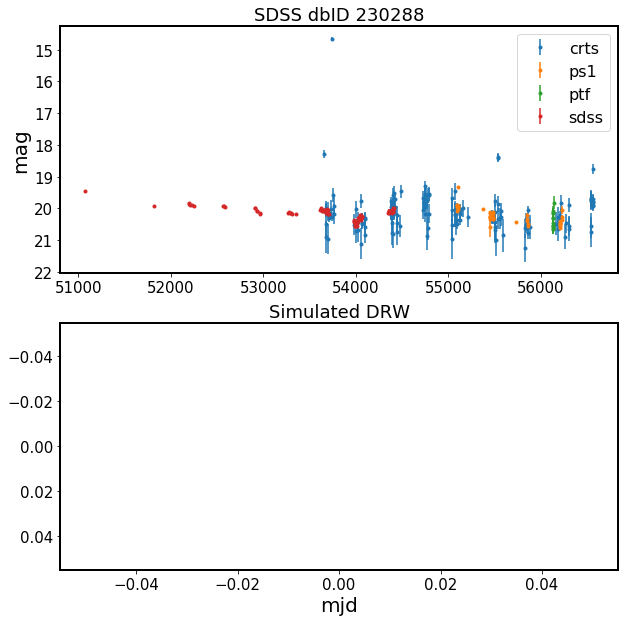

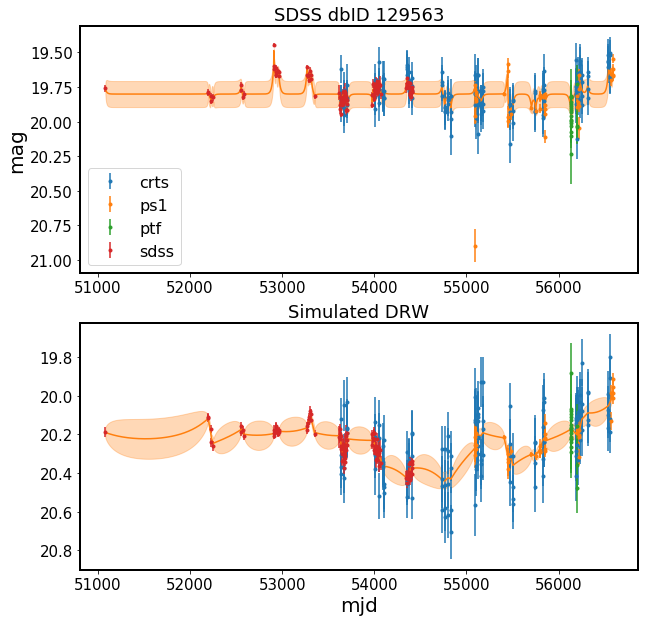

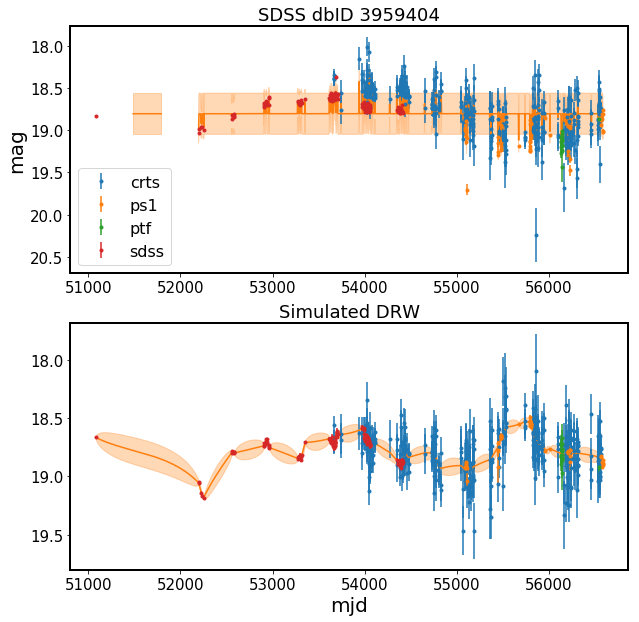

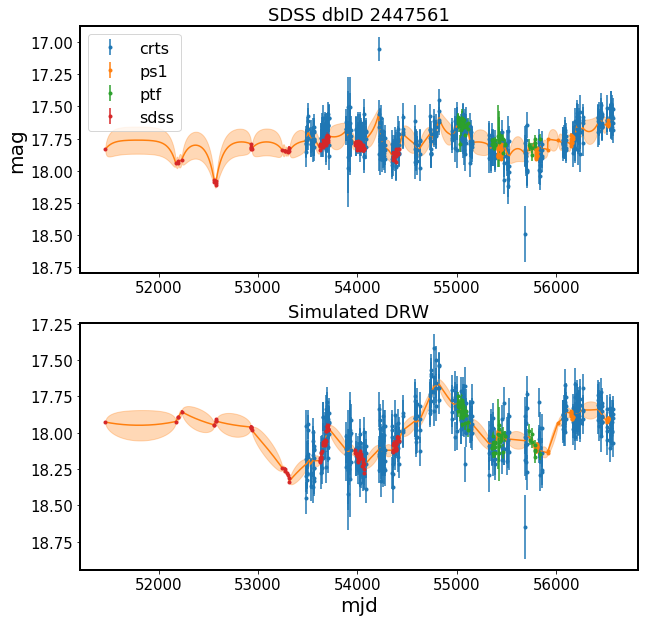

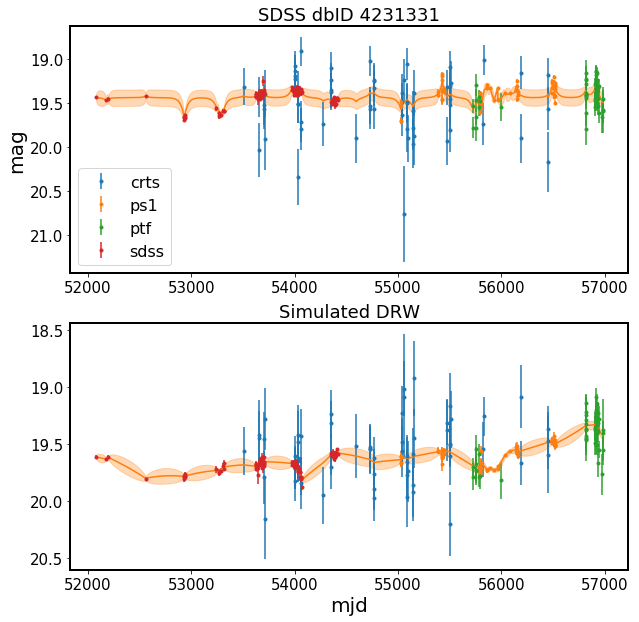

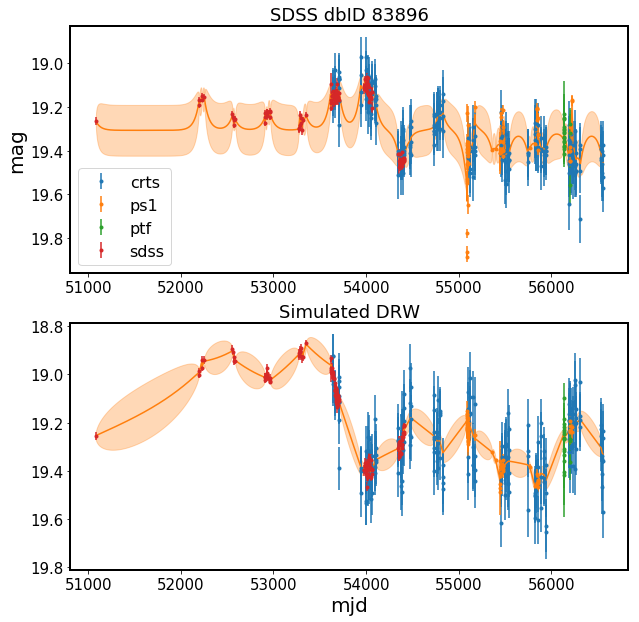

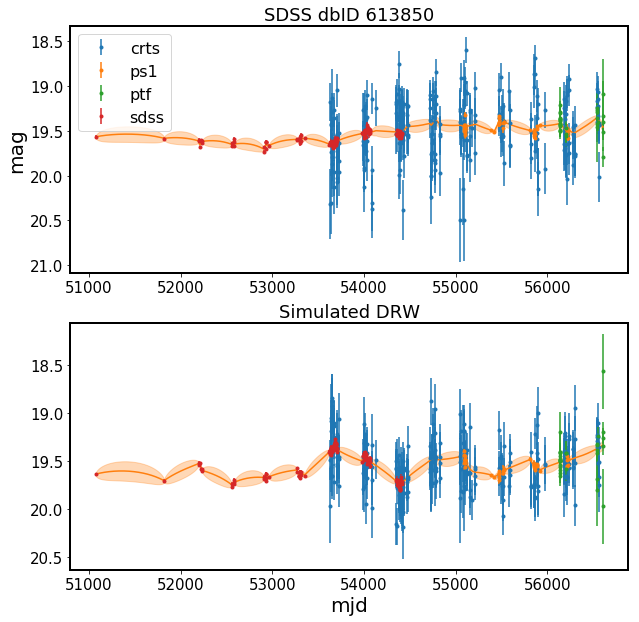

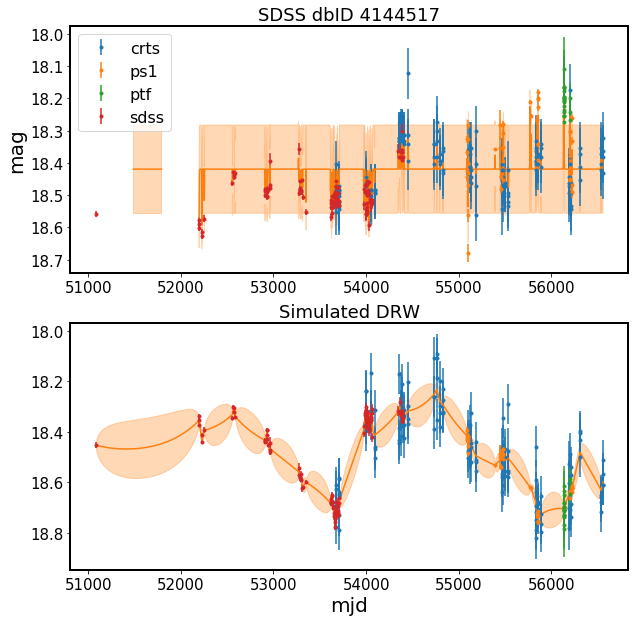

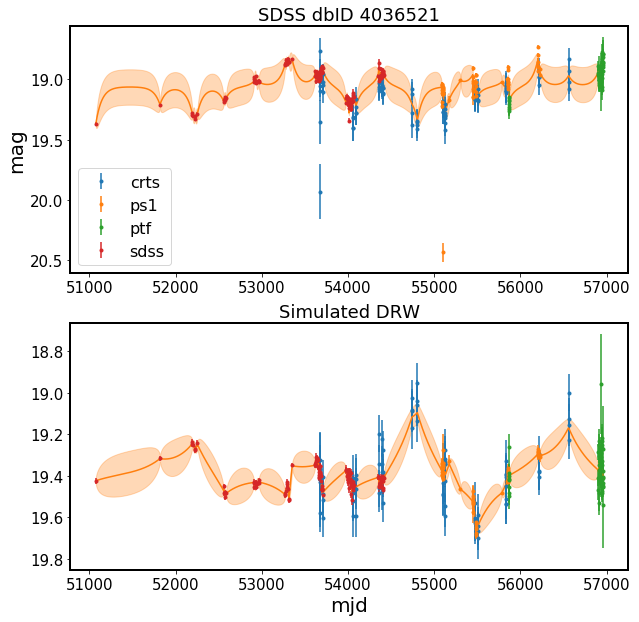

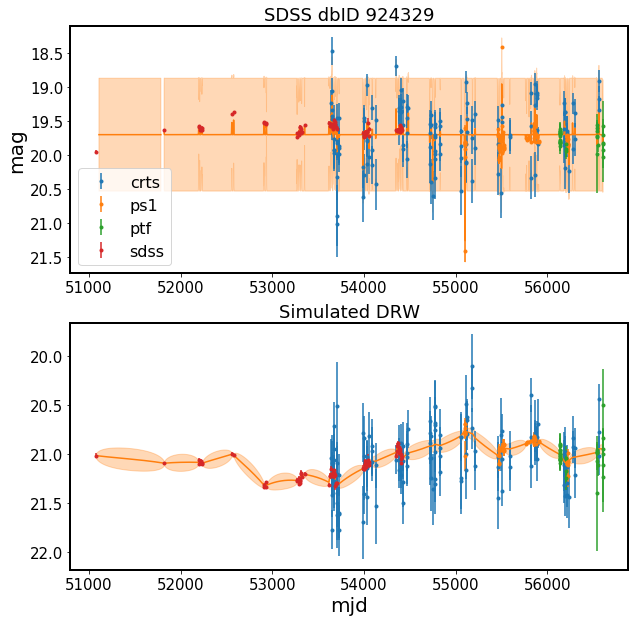

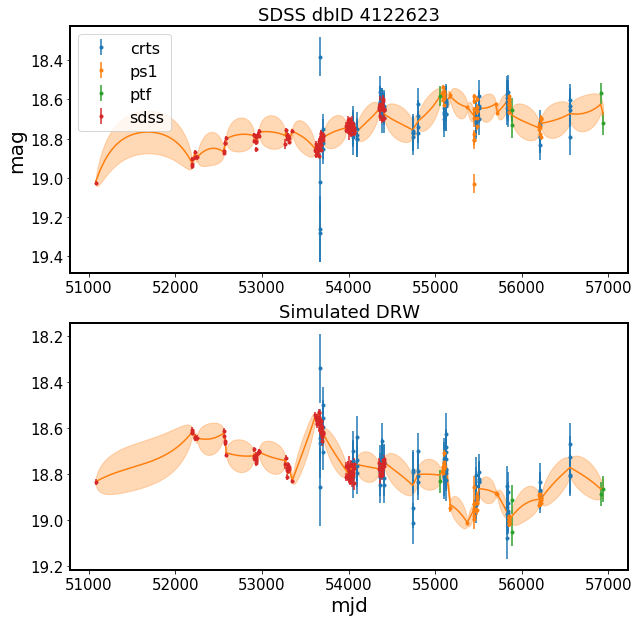

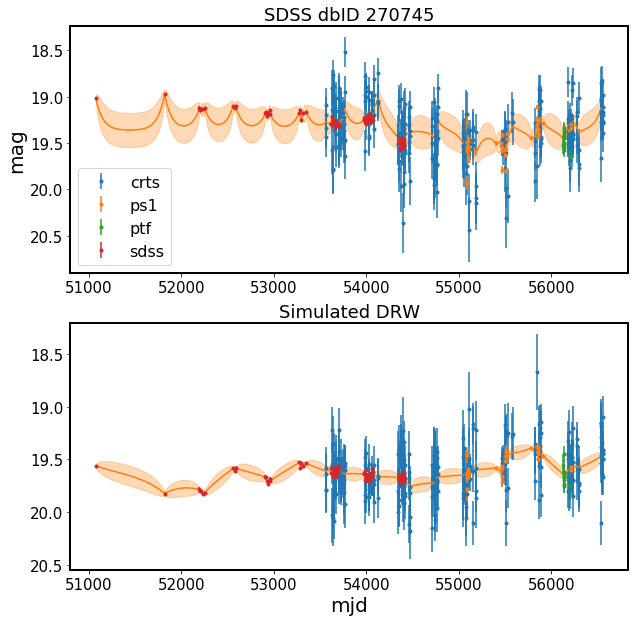

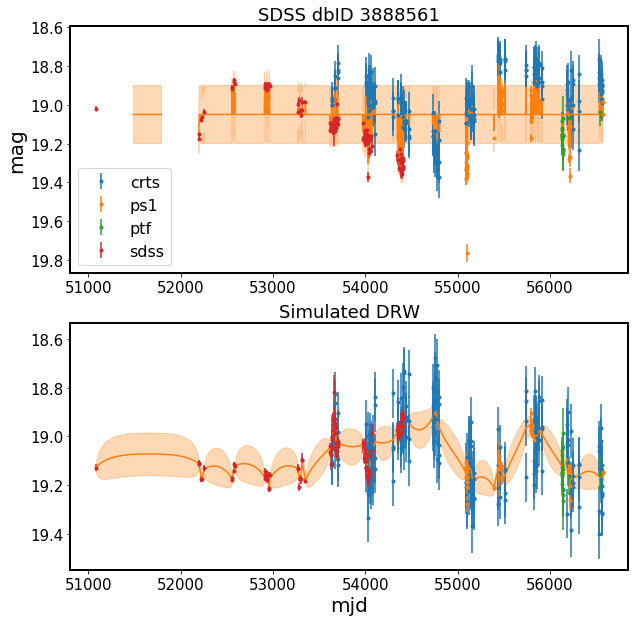

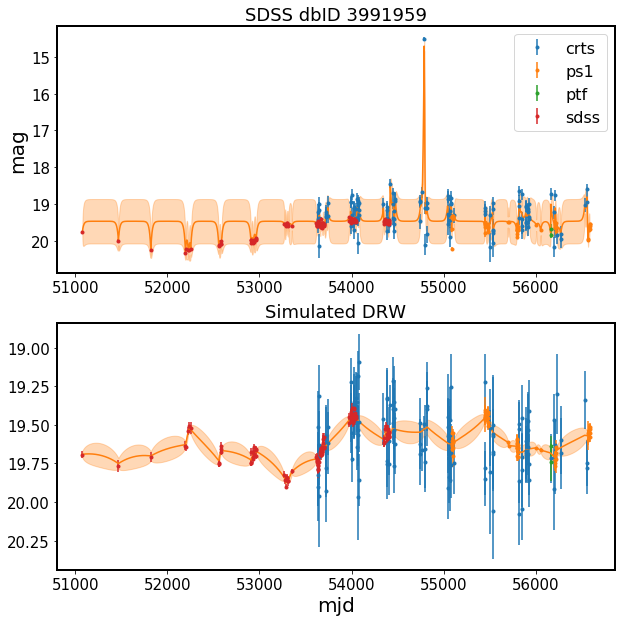

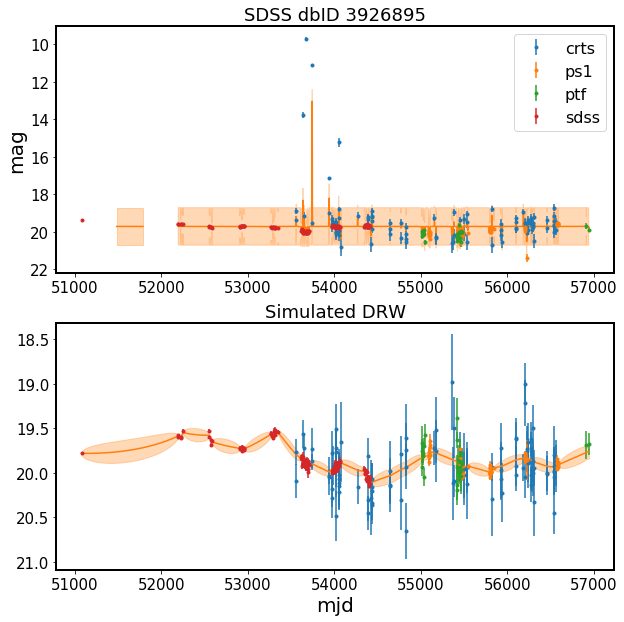

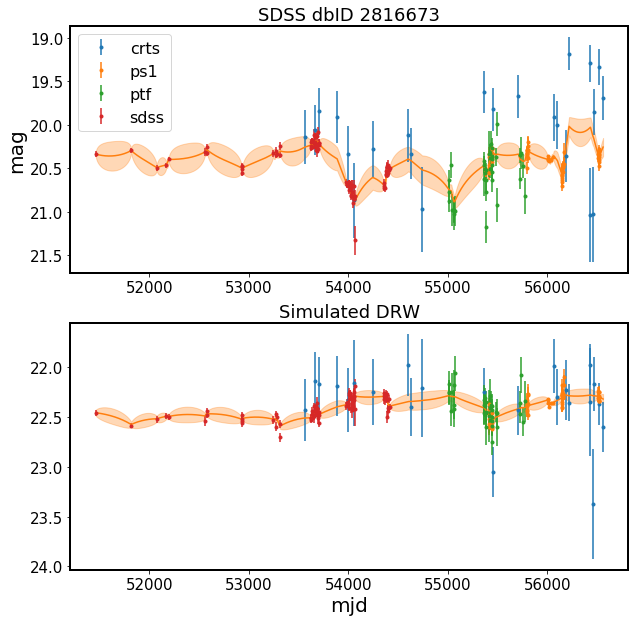

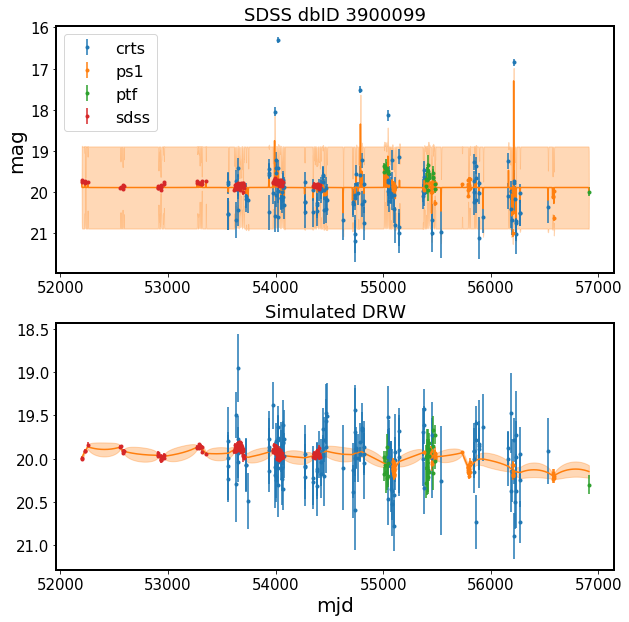

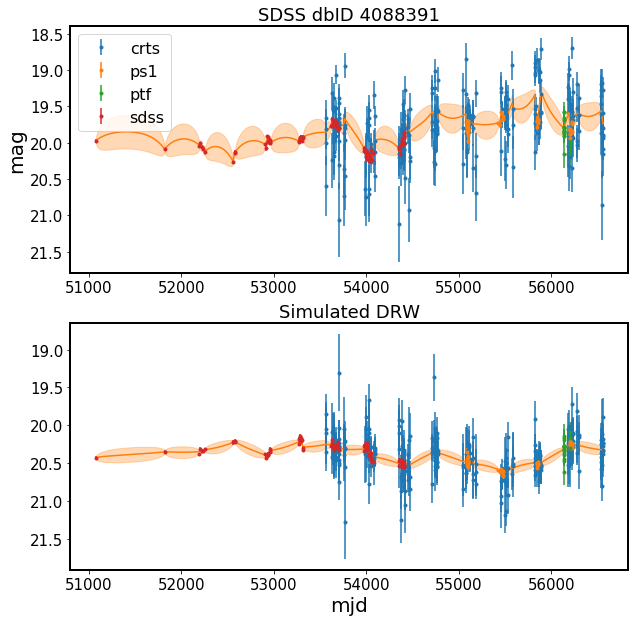

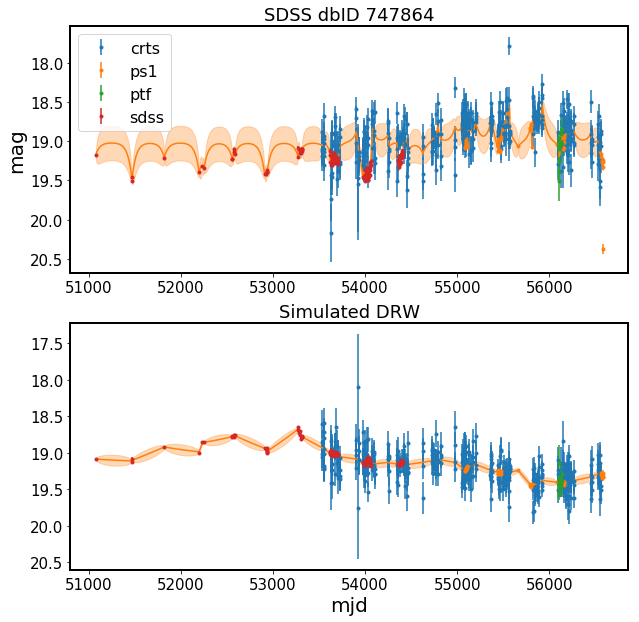

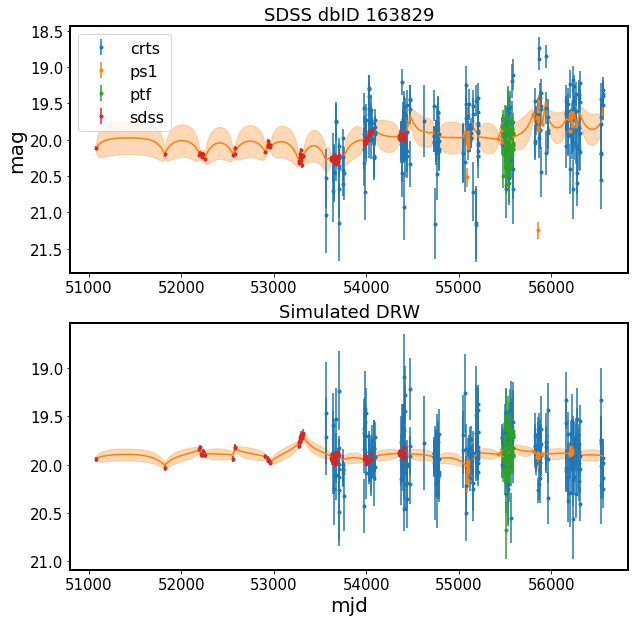

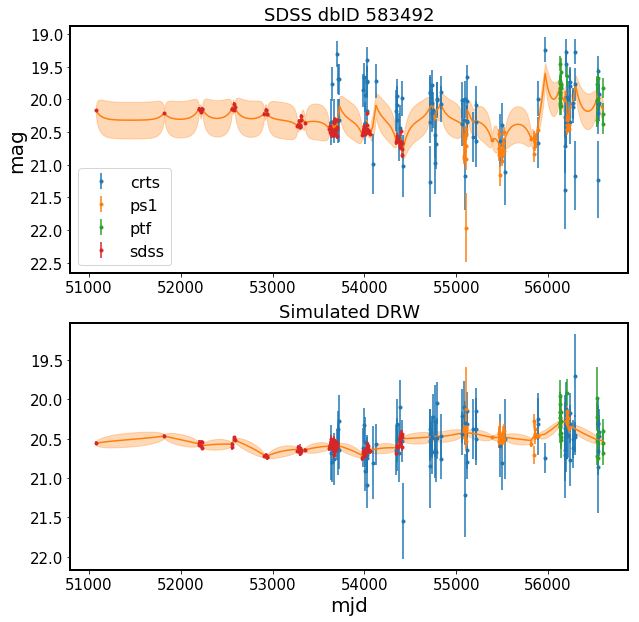

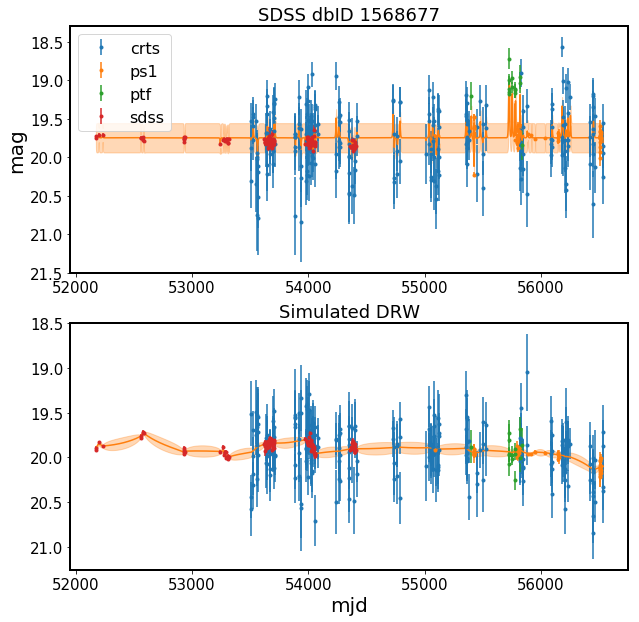

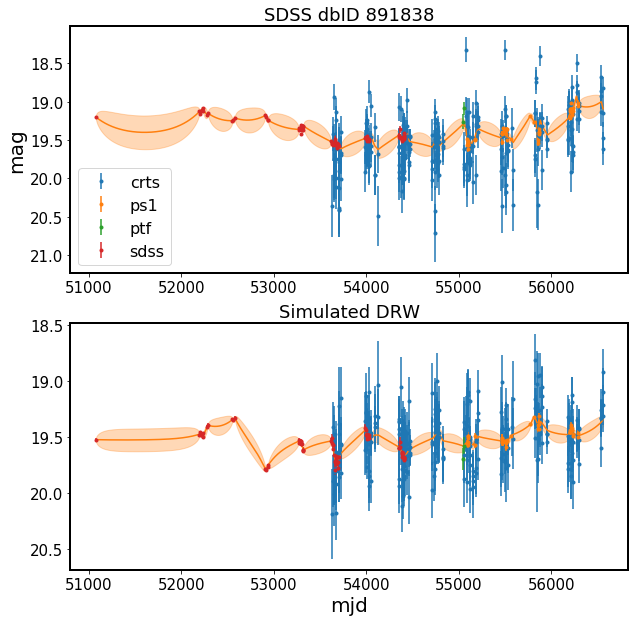

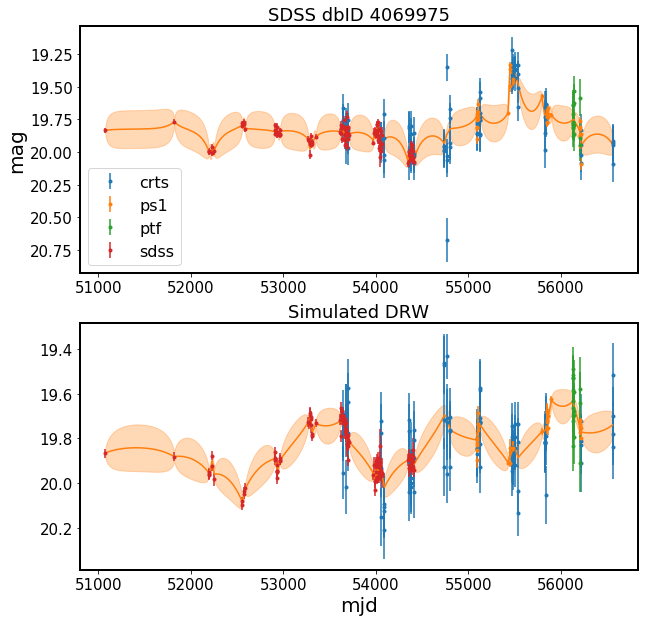

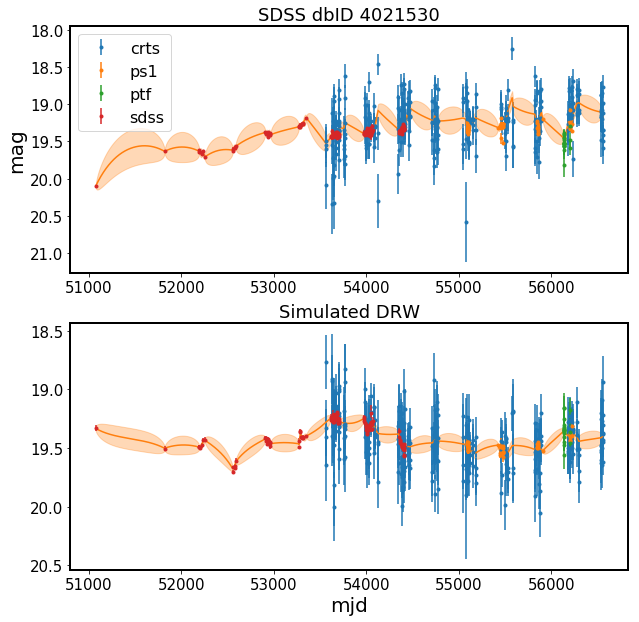

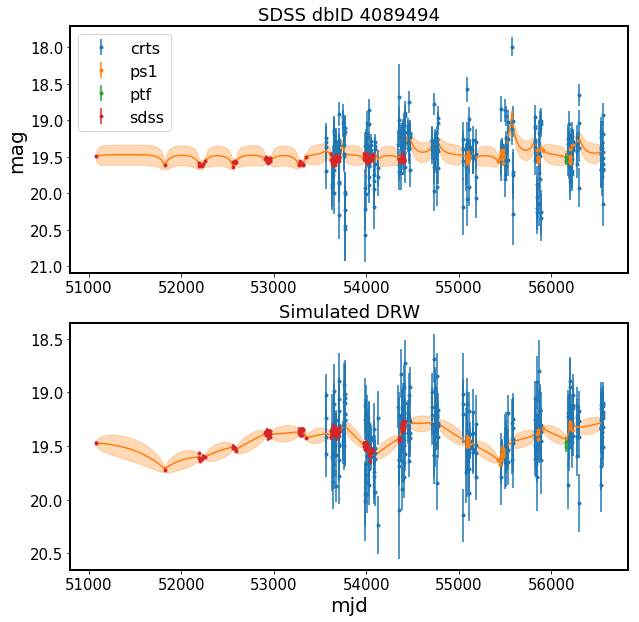

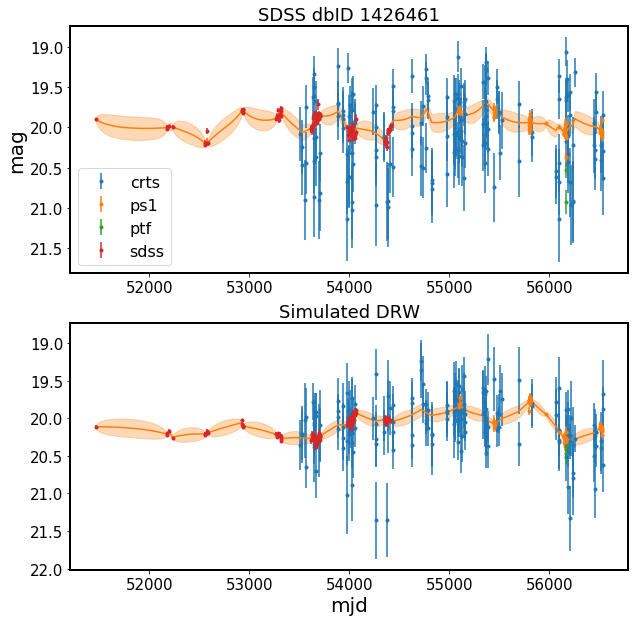

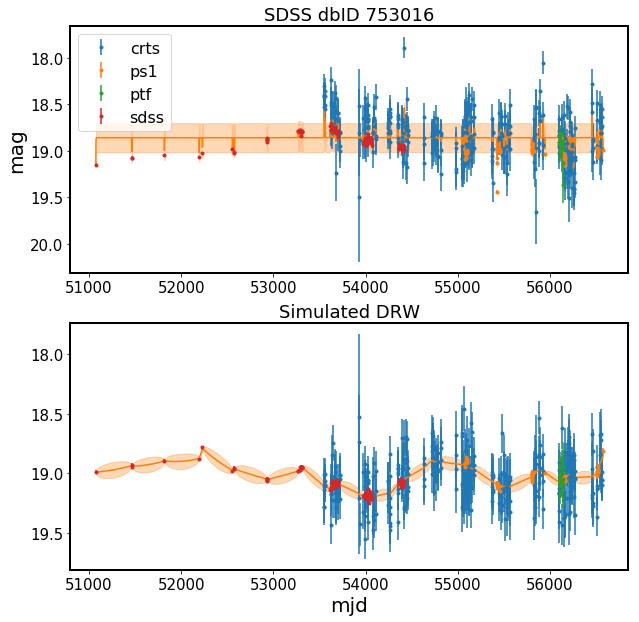

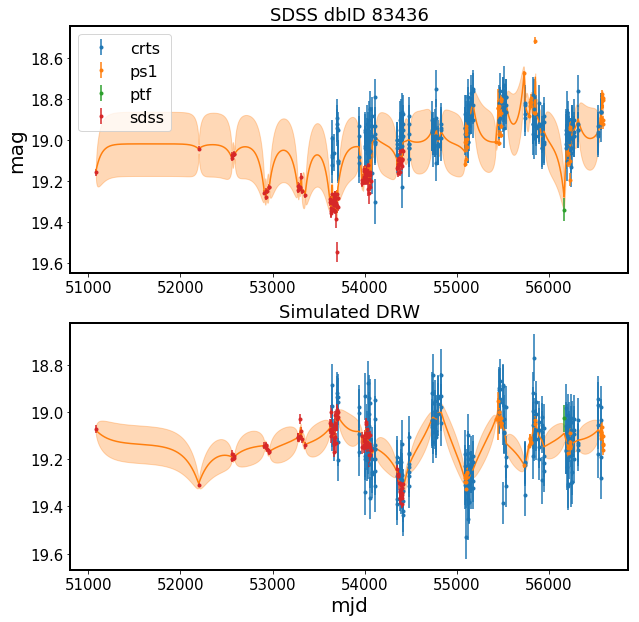

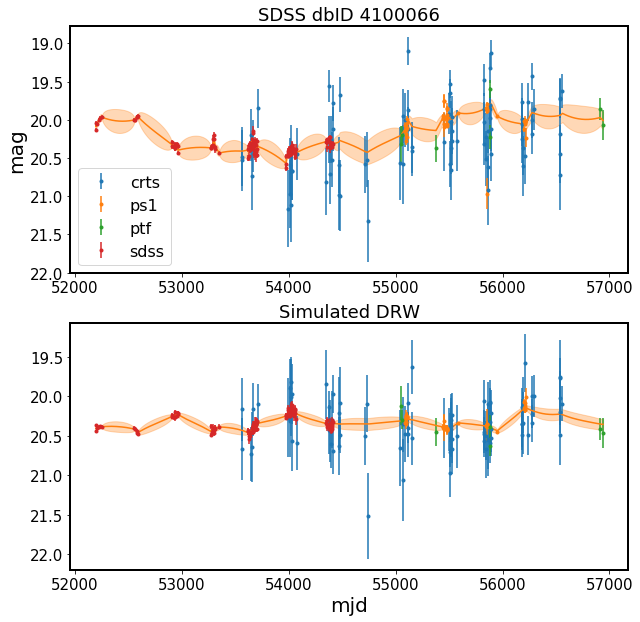

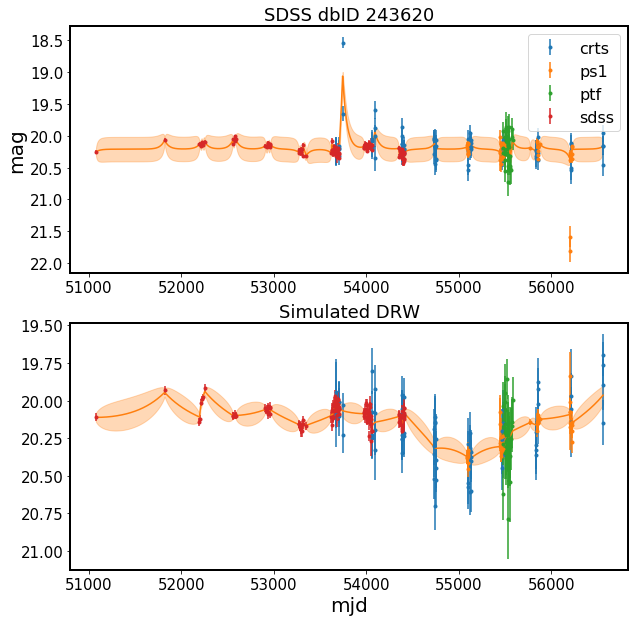

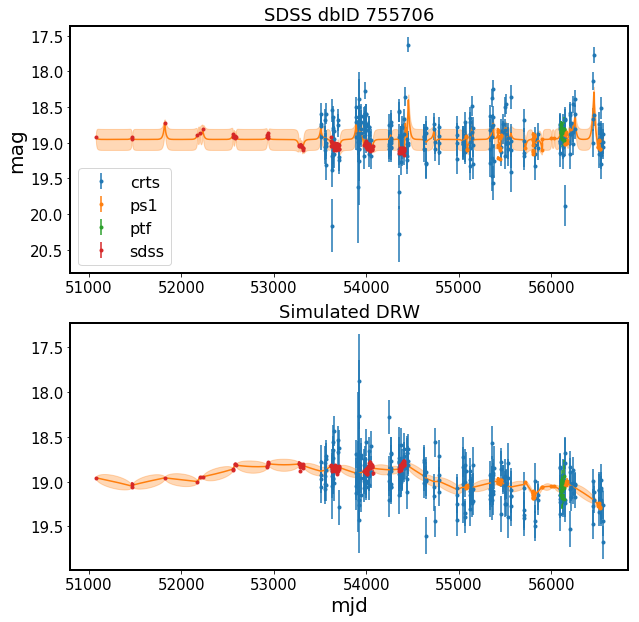

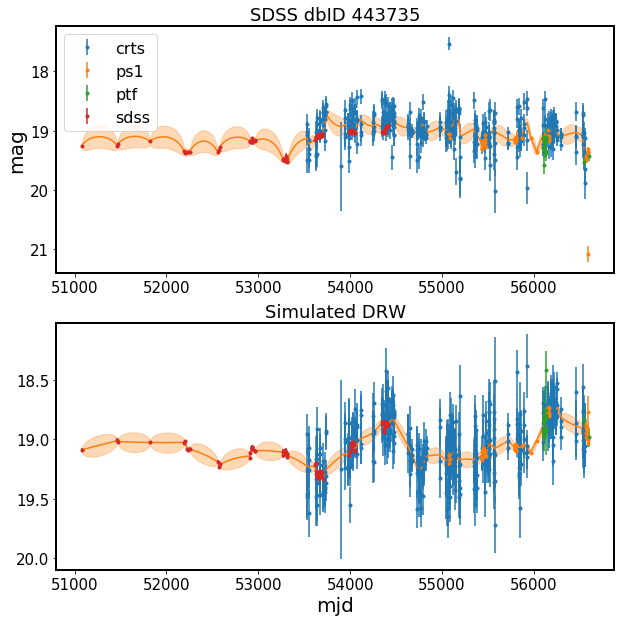

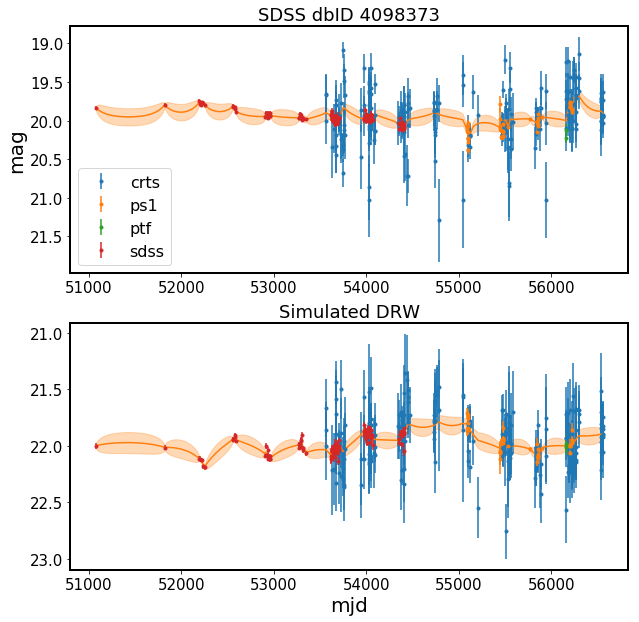

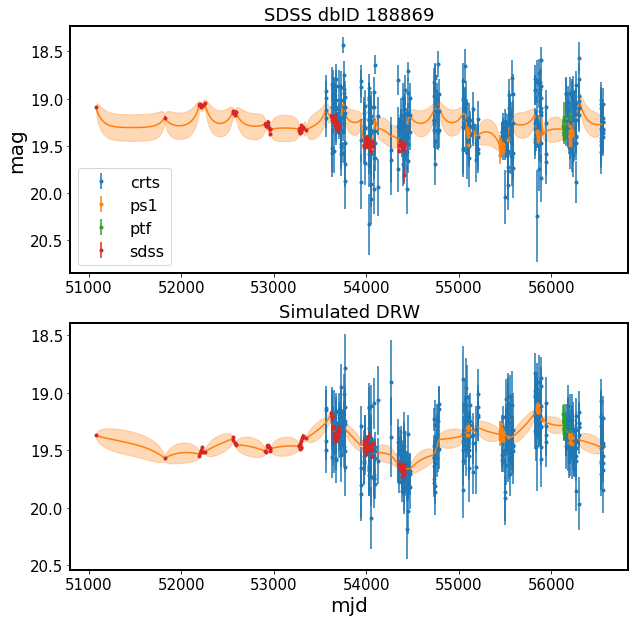

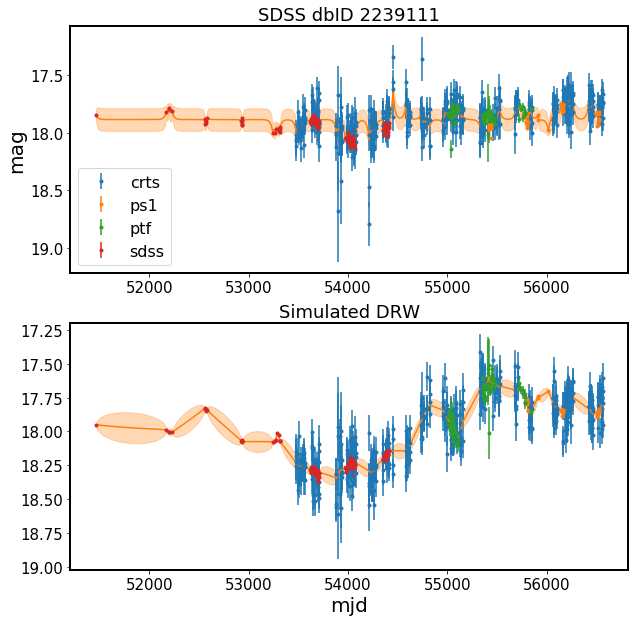

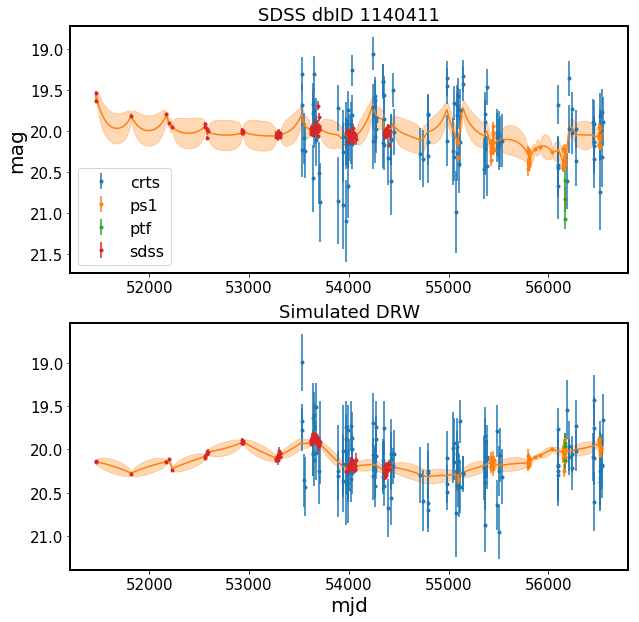

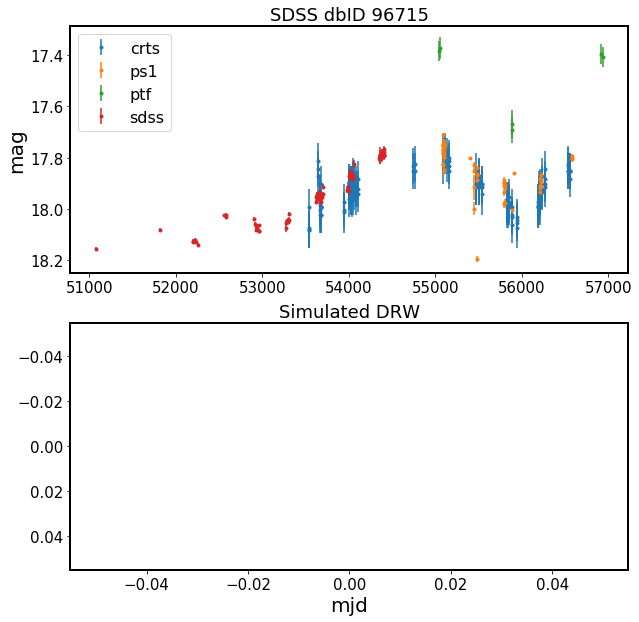

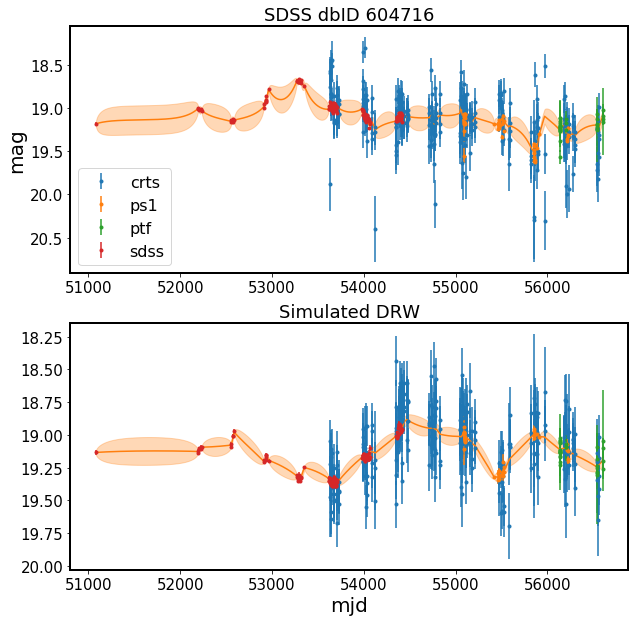

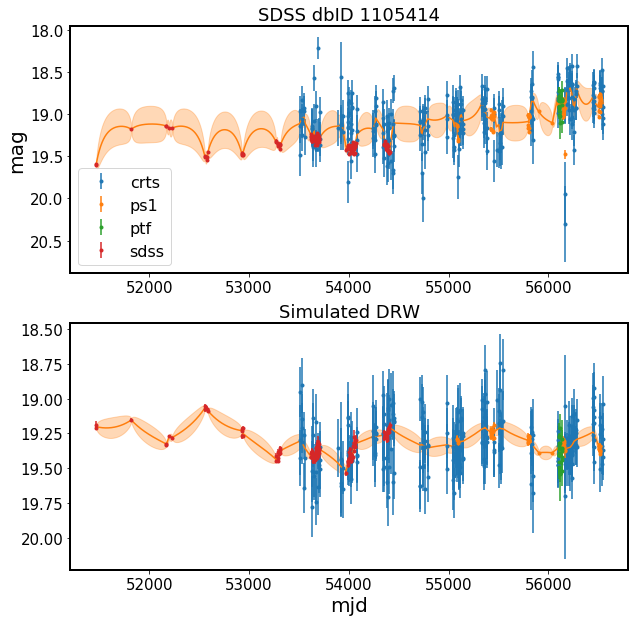

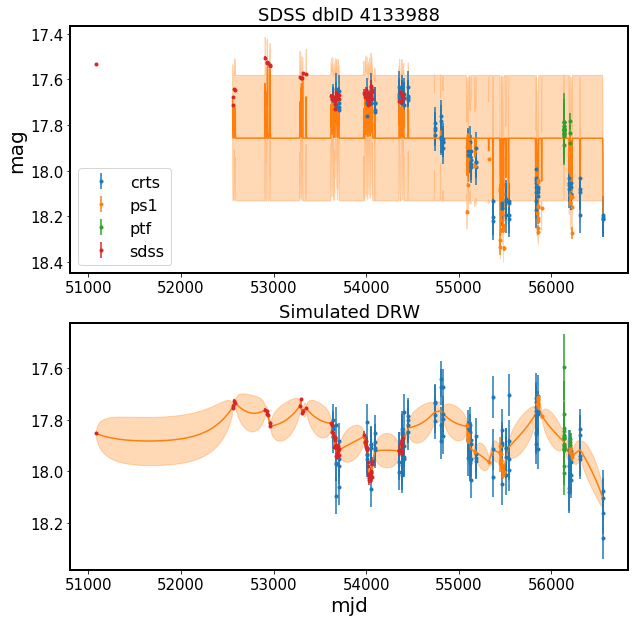

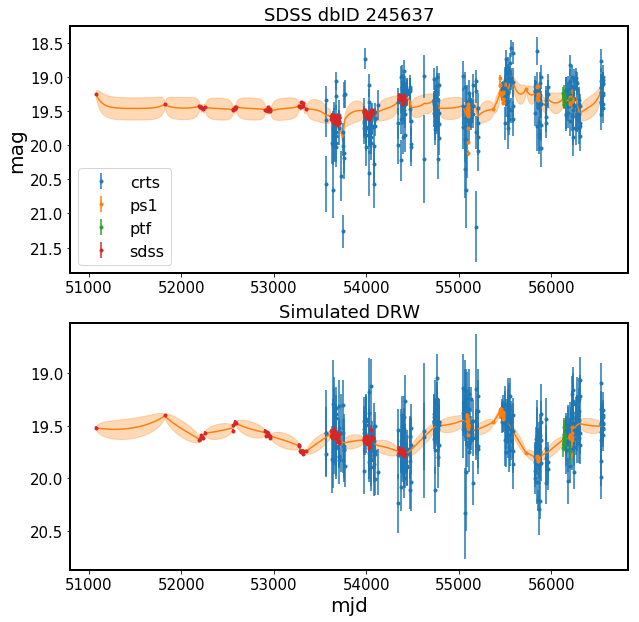

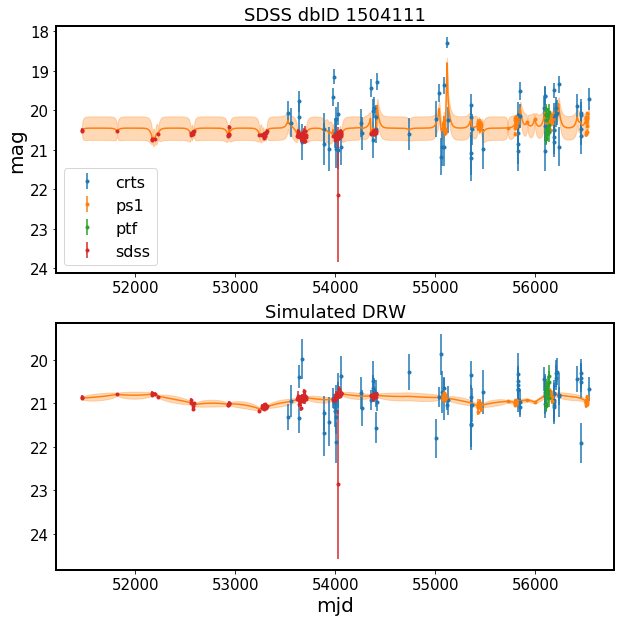

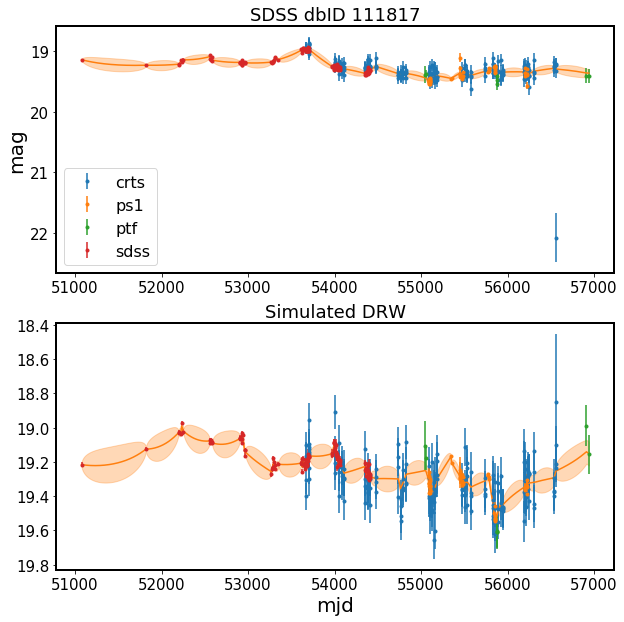

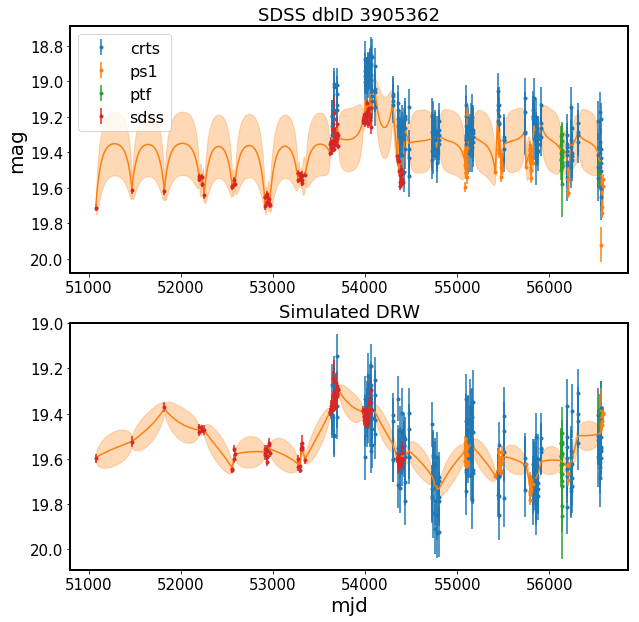

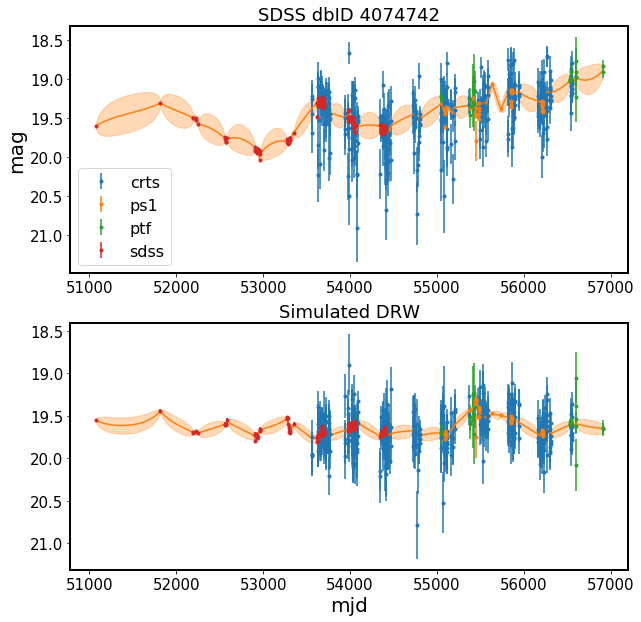

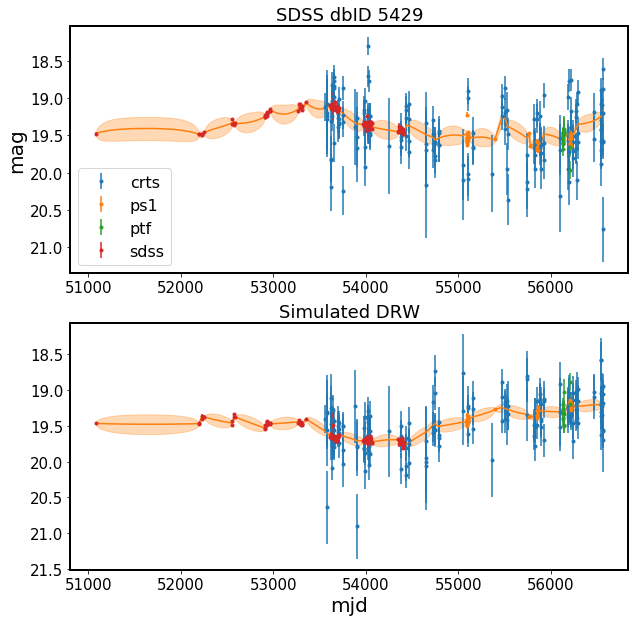

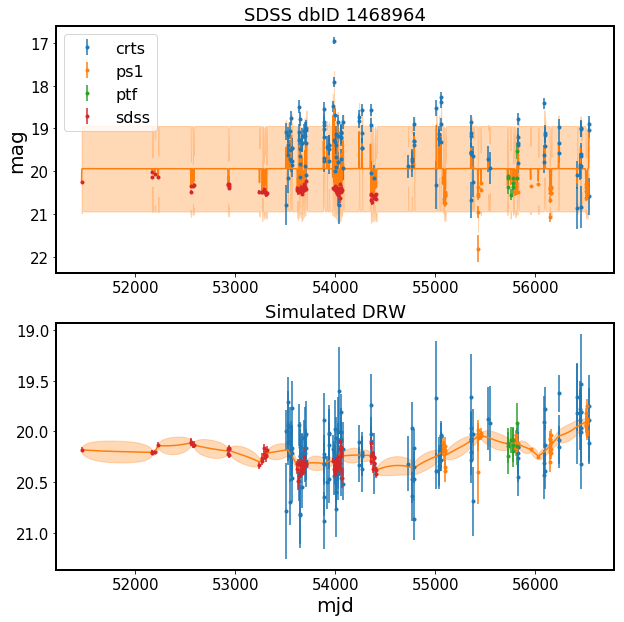

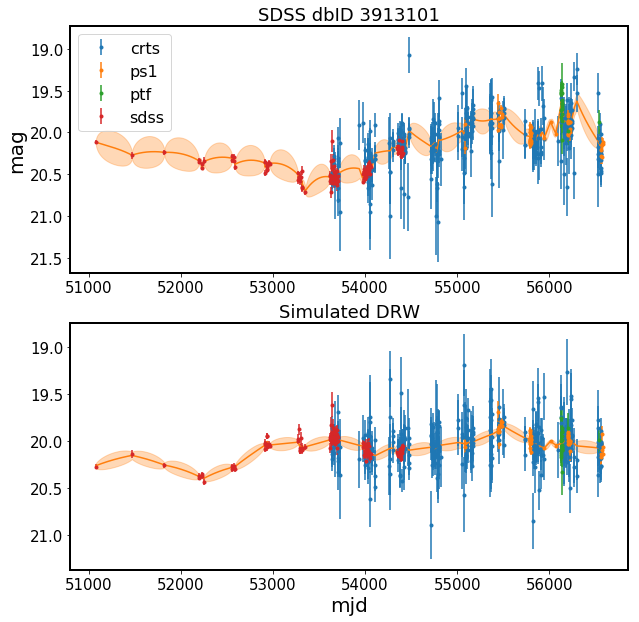

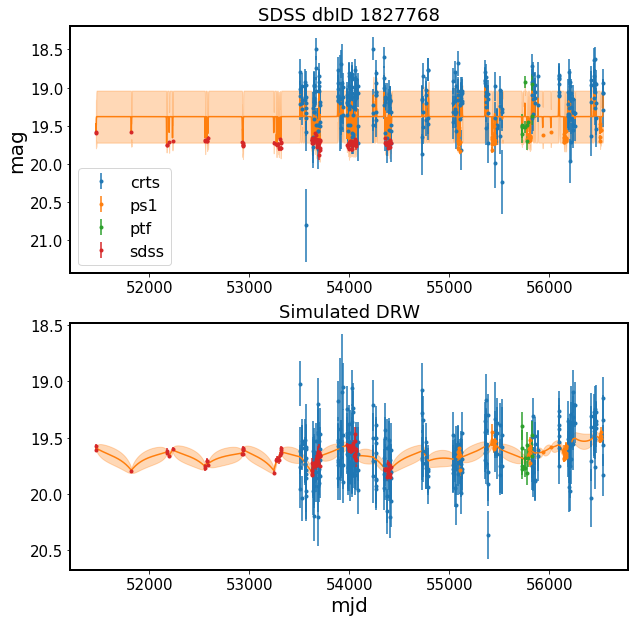

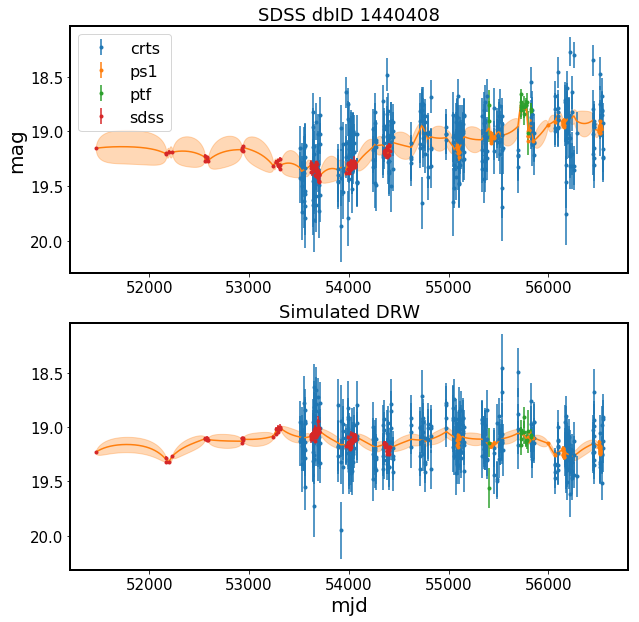

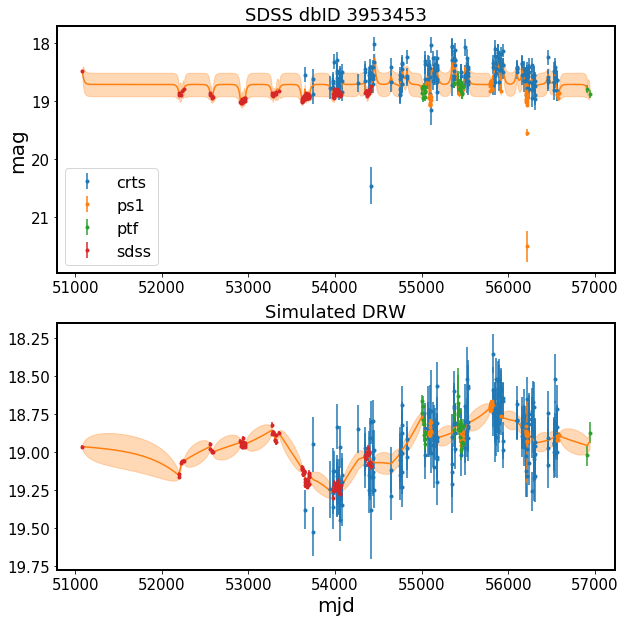

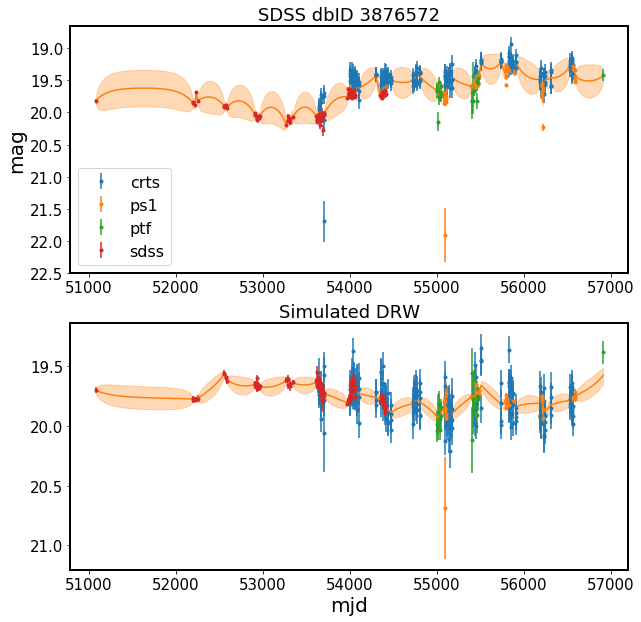

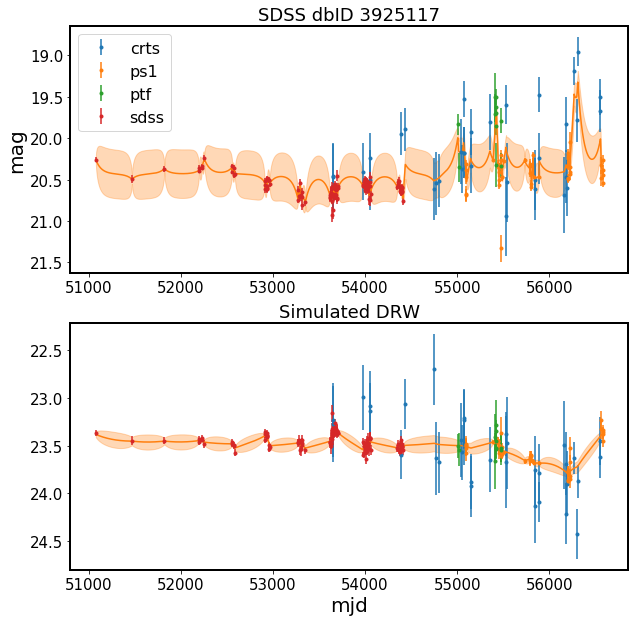

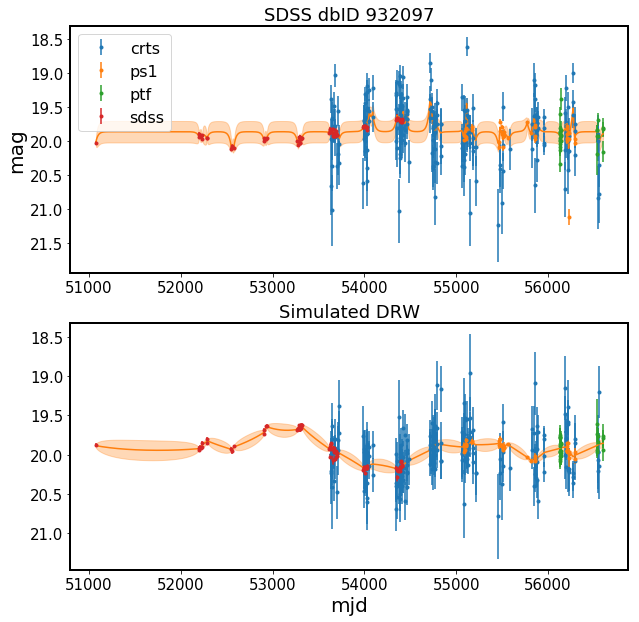

In [124]:



# Input parameters for simulated light curves ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# simulated light curves , stored at  mjd corresponding to real light curves 
simDir = '../data_products/Simulated_LC_DRW_true/'

# combined light curves 
saveDir = '../data_products/Combined_LC/'

lcs=  os.listdir(saveDir)

#i = 0
for i in range(len(lcs)):
    lcname = lcs[i]
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    lc_comb.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')

    # select the desired mjd from the simulated lc 
    lc_sim = Table.read(simDir + lcname, format='ascii')
    selection = np.in1d(lc_sim['mjd'], lc_comb['mjd'])
    lc_sel = lc_sim[selection].copy()

    # add the info about which timestamp corresponds to which survey 
    lc_sel['survey'] = lc_comb['originSurvey']

    # add the Gaussian noise corresponding to 
    # photometric uncertainty of each point 
    lc_sel['magerr'] = lc_comb['magerr']

    lc_obs = lc_sel.copy()
    lc_obs['mag'] = lc_obs['mag'] +  lc_obs['magerr'] * \
    np.random.normal(loc=0,scale=1,size=len(lc_obs))
    
    # make a plot 
    fig,ax  = plt.subplots(2,1,figsize=(10,10))
    for survey in np.unique(lc_comb['originSurvey']):
        m = lc_comb['originSurvey'] == survey

        # top plot   :  the combined light curve 
        ax[0].errorbar(lc_comb['mjd'][m], lc_comb['mag'][m], lc_comb['magerr'][m], 
                label=survey, fmt=".", capsize=0)
        # bottom plot 
        ax[1].errorbar(lc_obs['mjd'][m], lc_obs['mag'][m], lc_obs['magerr'][m], 
                    label=survey, fmt=".", capsize=0)

    fit_celerite(time=lc_comb['mjd'], mag=lc_comb['mag'], 
                 magerr=lc_comb['magerr'],axis=ax[0] )
    fit_celerite(time=lc_obs['mjd'], mag=lc_obs['mag'], 
                 magerr=lc_obs['magerr'],axis=ax[1] )


    # add labels and legends 
    ax[0].set_title('SDSS dbID '+ lcname[:-4])
    #ax[0].text(0.1,0.8, 'combined LC', transform = ax[0].transAxes,fontsize=16)
    #ax[1].text(0.1,0.8, 'simulated DRW', transform = ax[1].transAxes,fontsize=16)
    ax[1].set_title('Simulated DRW')
    ax[0].legend(fontsize=16)
    ax[1].set_xlabel('mjd')
    ax[0].set_ylabel('mag')
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()

    fname = '../data_products/Combined_LC_figs/'+lcname[:-4]+'_fit.png'
    plt.savefig(fname, bbox_inches='tight')
    print('Saved as ', fname )

### Fit the simulated LCs using entire segment (SDSS+PS1+PTF+CRTS)

it's a simpler version of what follows  - I keep it here before things get more complicated ... '

--> rerun with Jeff2  in iPython terminal.... 

In [128]:
# complete program to run in a terminal with %cpaste...
import numpy as np
from astropy.table import Table
from astropy.table import unique
import celerite
import modules as mod
import os 

# Fit all combined LCs  with Celerite ...
date = '181128'   # '181127
prior = 'Jeff2'   #  'Jeff1' 

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 


# simulated light curves , stored at  mjd corresponding to real light curves 
simDir = '../data_products/Simulated_LC_DRW_true/'

# simulated light curves sampled at the cadence of combined light curves, 
# with added Gaussian noise corresponding to the quoted 
# photometric uncertainty 
obsDir = '../data_products/Simulated_LC_DRW_obs/'

# combined light curves 
saveDir = '../data_products/Combined_LC/'

lcs=  os.listdir(saveDir)
results  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[],
                         'tauMAP':[], 'tauEXP':[] }

for i in range(len(lcs)):
    print(i)
    lcname = lcs[i]
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    lc_comb.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')

    # select the desired mjd from the simulated lc 
    lc_sim = Table.read(simDir + lcname, format='ascii')
    selection = np.in1d(lc_sim['mjd'], lc_comb['mjd'])
    lc_sel = lc_sim[selection].copy()

    # add the info about which timestamp corresponds to which survey 
    lc_sel['survey'] = lc_comb['originSurvey']

    # add the Gaussian noise corresponding to 
    # photometric uncertainty of each point 
    lc_sel['magerr'] = lc_comb['magerr']

    lc_obs = lc_sel.copy()
    lc_obs['mag'] = lc_obs['mag'] +  lc_obs['magerr'] * \
    np.random.normal(loc=0,scale=1,size=len(lc_obs))
    
    # save the observed LC 
    #lc_obs.write(obsDir+lcname, format='ascii')
    
    #####################################################
    ################## FITTING  #########################
    #####################################################
    
    # fit the observed LC with Celerite MAP and Expectation value ...

     # set limits for grid, MAP , and prior 
    sig_lims , tau_lims = [0.02,0.7], [1,5000]

    # find the Celerite expectation value and MAP 
    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc_obs['mjd'],lc_obs['mag'],
                              lc_obs['magerr'], 
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)

    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid, lc_obs['mag'], gp, prior)

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                            tau_grid)
    # store the results 
    results['lcname'].append(lcname)
    results['sigmaMAP'].append(sigmaMAP)
    results['sigmaEXP'].append(sigmaEXP)
    results['tauMAP'].append(tauMAP)
    results['tauEXP'].append(tauEXP)
    
    # store the fit 
    if i % 1000 == 0 : 
        # store the intermittent results : up to i-th file, 
        # for this combination of {survey, error} in a file ..
        fname = date  + '_Celerite_simulated_'+prior+'_'+str(i)+'.npy'
        print('Saved intermittent results up to i=',i, ' as ', fname)
        np.save(fname, results)
        
# store the final thing...
fname = date + '_Celerite_simulated_'+prior+'.npy'
print('Saved final Celerite results  to ', fname)
np.save(fname, results)

   

0


Saved intermittent results up to i= 0  as  181127_Celerite_simulated_0.npy
1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


43
44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


335
336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


599


600


601


602


603


604


605


606


607


608


609


610


611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627


628


629


630


631


632


633


634


635


636


637


638


639


640


641


642


643


644


645


646


647


648


649


650


651


652


653


654


655


656


657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676


677


678


679


680


681


682


683


684


685


686


687


688


689


690


691


692


693


694


695


696


697


698


699


700


701


702


703


704


705


706


707


708


709


710


711


712


713


714


715


716


717


718


719


720


721


722


723


724


725


726


727


728


729


730


731


732


733


734


735


736


737


738


739


740


741


742


743


744


745


746


747


748


749


750


751


752


753


754


755


756


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


757
758


759


760


761


762


763


764


765


766


767


768


769


770


771


772


773


774


775


776


777


778


779


780


781


782


783


784


785


786


787


788


789


790


791


792


793


794


795


796


797


798


799


800


801


802


803


804


805


806


807


808


809


810


811


812


813


814


815


816


817


818


819


820


821


822


823


824


825


826


827


828


829


830


831


832


833


834


835


836


837


838


839


840


841


842


843


844


845


846


847


848


849


850


851


852


853


854


855


856


857


858


859


860


861


862


863


864


865


866


867


868


869


870


871


872


873


874


875


876


877


878


879


880


881


882


883


884


885


886


887


888


889


890


891


892


893


894


895


896


897


898


899


900


901


902


903


904


905


906


907


908


909


910


911


912


913


914


915


916


917


918


919


920


921


922


923


924


925


926


927


928


929


930


931


932


933


934


935


936


937


938


939


940


941


942


943


944


945


946


947


948


949


950


951


952


953


954


955


956


957


958


959


960


961


962


963


964


965


966


967


968


969


970


971


972


973


974


975


976


977


978


979


980


981


982


983


984


985


986


987


988


989


990


991


992


993


994


995


996


997


998


999


1000


Saved intermittent results up to i= 1000  as  181127_Celerite_simulated_1000.npy
1001


1002


1003


1004


1005


1006


1007


1008


1009


1010


1011


1012


1013


1014


1015


1016


1017


1018


1019


1020


1021


1022


1023


1024


1025


1026


1027


1028


1029


1030


1031


1032


1033


1034


1035


1036


1037


1038


1039


1040


1041


1042


1043


1044


1045


1046


1047


1048


1049


1050


1051


1052


1053


1054


1055


1056


1057


1058


1059


1060


1061


1062


1063


1064


1065


1066


1067


1068


1069


1070


1071


1072


1073


1074


1075


1076


1077


1078


1079


1080


1081


1082


1083


1084


1085


1086


1087


1088


1089


1090


1091


1092


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


1093
1094


1095


1096


1097


1098


1099


1100


1101


1102


1103


1104


1105


1106


1107


1108


1109


1110


1111


1112


1113


1114


1115


1116


1117


1118


1119


1120


1121


1122


1123


1124


1125


1126


1127


1128


1129


1130


1131


1132


1133


1134


1135


1136


1137


1138


1139


1140


1141


1142


1143


1144


1145


1146


1147


1148


1149


1150


1151


1152


1153


1154


1155


1156


1157


1158


1159


1160


1161


1162


1163


1164


1165


1166


1167


1168


1169


1170


1171


1172


1173


1174


1175


1176


1177


1178


1179


1180


1181


1182


1183


1184


1185


1186


1187


1188


1189


1190


1191


1192


1193


1194


1195


1196


1197


1198


1199


1200


1201


1202


1203


1204


1205


1206


1207


1208


1209


1210


1211


1212


1213


1214


1215


1216


1217


1218


1219


1220


1221


1222


1223


1224


1225


1226


1227


1228


1229


1230


1231


1232


1233


1234


1235


1236


1237


1238


1239


1240


1241


1242


1243


1244


1245


1246


1247


1248


1249


1250


1251


1252


1253


1254


1255


1256


1257


1258


1259


1260


1261


1262


1263


1264


1265


1266


1267


1268


1269


1270


1271


1272


1273


1274


1275


1276


1277


1278


1279


1280


1281


1282


1283


1284


1285


1286


1287


1288


1289


1290


1291


1292


1293


1294


1295


1296


1297


1298


1299


1300


1301


1302


1303


1304


1305


1306


1307


1308


1309


1310


1311


1312


1313


1314


1315


1316


1317


1318


1319


1320


1321


1322


1323


1324


1325


1326


1327


1328


1329


1330


1331


1332


1333


1334


1335


1336


1337


1338


1339


1340


1341


1342


1343


1344


1345


1346


1347


1348


1349


1350


1351


1352


1353


1354


1355


1356


1357


1358


1359


1360


1361


1362


1363


1364


1365


1366


1367


1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
Saved intermittent results up to i= 5000  as  181127_Celerite_simulated_5000.npy
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960


### Investigate fit results : simulation , whole LC (SDSS+PS1+PTF+CRTS)

In [129]:
#prior = 'Jeff1' ; date = '181127'  already done 
prior = 'Jeff2' ; date = '181128'  # running in iPython
r = np.load(date + '_Celerite_simulated_'+prior+'.npy').item()

In [136]:
r.keys()

dict_keys(['lcname', 'sigmaMAP', 'sigmaEXP', 'tauMAP', 'tauEXP'])

In [156]:
mod.find_celerite_MAP??

In [157]:
mod.neg_log_posterior??

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


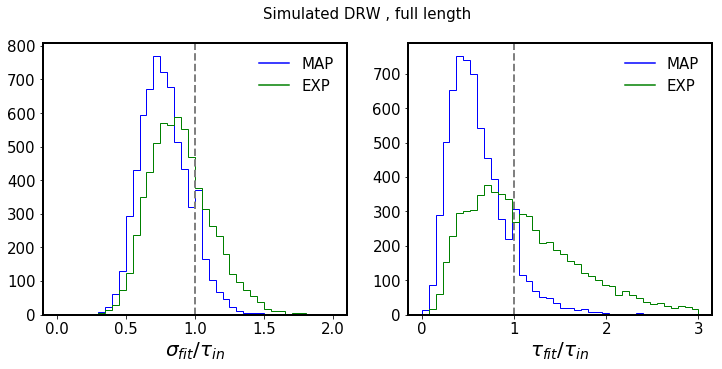

In [158]:
import matplotlib.lines as mlines

fig,ax = plt.subplots(1,2, figsize=(12,5))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []
prior  = 'Jeff1'
ax[0].hist(r['sigmaMAP'] / sigma_in , histtype='step', bins=40, range=[0,2], 
          color = colors[0]) 
ax[0].hist(r['sigmaEXP'] / sigma_in , histtype='step', bins=40, range=[0,2], 
          color = colors[1]) 
ax[0].set_xlabel(r'$\sigma_{fit} / \tau_{in}$')



ax[1].hist(np.asarray(r['tauMAP']) / float(tau_in) , histtype='step', bins=40,
          range=[0,3],  color = colors[0]) 
ax[1].hist(np.asarray(r['tauEXP']) / float(tau_in) , histtype='step', bins=40,
          range=[0,3],  color = colors[1]) 
ax[1].set_xlabel(r'$\tau_{fit} / \tau_{in}$')

line = mlines.Line2D([], [],  color=colors[0], label='MAP')
ax_legend_handles.append(line)
line = mlines.Line2D([], [],  color=colors[1], label='EXP')
ax_legend_handles.append(line)

ax[0].legend(loc='upper right', handles = ax_legend_handles, frameon=False,
                 fontsize=15,)
ax[1].legend(loc='upper right', handles = ax_legend_handles, frameon=False,
                 fontsize=15,)
ax[0].axvline(1, lw=2, ls='--', c='grey')
ax[1].axvline(1, lw=2, ls='--', c='grey')

fig.suptitle('Simulated DRW , full length' , fontsize = 15)
plt.savefig('SimDRW_full_length_'+prior+'.png', bbox_inches="tight")

This is in line with the Kozlowski+2017 Fig.2 that I reproduced earlier . Here the input timescale was 575 days,  so for most light curves their length is just below 10 times that, thus some bias is to be expected.  

### Fit simulation and real DRW using segments and whole, store the results (as above , but splitting light curves into segments: SDSS, SDSS+PS1,  SDSS+PS1+PTF,  etc. )  

Similar as ** AB_simulate_combined_LCs** , but I use the combined light curves ( consisting of SDSS(r),  and SDSS_synthetic(r),  derived from CRTS(V),  PTF(gR),  PS1(gri), via SDSS(g-i) color ) . 

The simulated DRW (that was all simulated with identical input timescale and amplitude, and sampled at real MJDs of SDSS(ugriz), PTF(gR), PS1(grizy), CRTS(V) ) is sampled at time stamps corresponding to the combined light curves. The errors correspond to real photometric errors at each time stamp ; the appropriate Gaussian noise was added to the simulated DRW signal. 

We fit either points from SDSS(r),   SDSS(r) + SDSS(r, from PTF(gR)) : sections of the light curve that eventually use the entire light curve. In that way we show how adding more data improves the fit. 

Even using all data is biased low : this is expected based on Fig.2 in Kozlowski+2017, that we independently confirmed for Celerite (both MAP and EXP, but EXP less biased). 

For each light curve we note the length of the considered segment  - related to the fitted (or input) timescale it tells us the 'fidelity' of that fit .  (  if rho = input_timescale / baseline < 10 ,  then probably the fit is unbiased,  but if it is above 10, then probably it is ...  ( corresponding to the Fig.2 : the general features are unchanged regardless of number of points (whether SDSS with N=60 pts, or OGLE with N=445 points ... ). The combined light curves fall somewhere in between -  so Fig.2 is a good diagnostic. 

To be perfect,  one would make an equivalent of Fig.2 for each light curve ( given the particular combination of (Npoints, errors, baseline), simulate a range of timescales so that rho between 0.01 to 100 is sampled,  at each rho do 1000 realizations of the same DRW..., and make Fig.2 for that light curve)  this would allow the most accurate estimate of the fit accuracy (vertical spread in Fig.2 at x = fitted rho ) , and bias (offset from y=x on Fig.2) .  

In [174]:
def fit_with_celerite(lc, lcname, dic, prior='Jeff2'): 
    # fit the observed simulated LC and real LC 
    # with Celerite MAP and Expectation value ...
    
    # set limits for grid, MAP , and prior 
    sig_lims , tau_lims = [0.02,0.7], [1,5000]

    # find the Celerite expectation value and MAP 
    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc['mjd'],lc['mag'],
                              lc['magerr'], 
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)
    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid, lc['mag'], gp, prior)

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                            tau_grid)

    # store the results 
    dic['sigmaMAP'].append(sigmaMAP)
    dic['sigmaEXP'].append(sigmaEXP)
    dic['tauMAP'].append(tauMAP)
    dic['tauEXP'].append(tauEXP)
    dic['lcname'].append(lcname)
    dic['length'].append(max(lc['mjd']) - min(lc['mjd']))

In [186]:
# Fit all combined LCs  with Celerite ...
date = '181128'   # '181127
prior = 'Jeff2'   #  'Jeff1' 

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# simulated light curves , stored at  mjd corresponding to real light curves 
simDir = '../data_products/Simulated_LC_DRW_true/'

# simulated light curves sampled at the cadence of combined light curves, 
# with added Gaussian noise corresponding to the quoted 
# photometric uncertainty 
obsDir = '../data_products/Simulated_LC_DRW_obs/'

# combined light curves 
saveDir = '../data_products/Combined_LC/'

lightcurve_list =  os.listdir(saveDir)

# define the storage dictionary .... 
results = {}
segments  = ['sdss', 'sdss-ps1', 'sdss-ps1-ptf', 'sdss-ps1-ptf-crts']
sims = ['simulated', 'real']
for sim in sims : 
    results[sim] = {}
    for segment in segments : 
        results[sim][segment]  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[], 
                                   'tauMAP':[], 'tauEXP':[],
                                  'length':[]
                                 }
for i in range(len(lightcurve_list)):
    print(i)
    lcname = lightcurve_list[i]
    lc_comb = Table.read(saveDir+lcname, format='ascii')
    lc_comb.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_comb = unique(lc_comb, keys='mjd', keep='first')
    lc_comb.rename_column('originSurvey', 'survey')
    # select the desired mjd from the simulated lc 
    #lc_sim = Table.read(simDir + lcname, format='ascii')
    #selection = np.in1d(lc_sim['mjd'], lc_comb['mjd'])
    #lc_sel = lc_sim[selection].copy()

    # add the info about which timestamp corresponds to which survey 
    #lc_sel['survey'] = lc_comb['originSurvey']

    # add the Gaussian noise corresponding to 
    # photometric uncertainty of each point 
    #lc_sel['magerr'] = lc_comb['magerr']

    #lc_obs = lc_sel.copy()
    #lc_obs['mag'] = lc_obs['mag'] +  lc_obs['magerr'] * \
    #np.random.normal(loc=0,scale=1,size=len(lc_obs))
    
    # store 
    # lc_obs.write(obsDir+lcname, format='ascii')
    
    # read in  the observed LC : already done the steps above earlier 
    lc_obs = Table.read(obsDir + lcname , format='ascii')
    
    #################
    #     Fit       #
    #################
    # Take simulated, then the real light curve 
    for lcs , sim in zip( [lc_obs, lc_comb] , sims) :
        # take segments of each light curve ... 
        for segment in segments : 
            lc = lcs[np.in1d(lcs['survey'], segment.split(sep='-'))]
            #print(results[sim][segment])
            fit_with_celerite(lc,lcname , results[sim][segment] , 'Jeff2')
    
    # store the fit 
    if i % 1000 == 0 : 
        # store the intermittent results : up to i-th file, 
        # for this combination of {survey, error} in a file ..
        fname = date + '_Celerite_sim_and_real_'+prior+'_'+str(i)+'.npy'
        print('Saved intermittent results up to i=',i, ' as ', fname)
        np.save(fname, results)
        
# store the final thing...
fname = date + '_Celerite_sim_and_real_'+prior+'.npy'
print('Saved final Celerite results  to ', fname)
np.save(fname, results)

   

0
Saved intermittent results up to i= 0  as  181128_Celerite_sim_and_real_Jeff2_0.npy
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
3

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
Saved intermittent resu

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
Saved intermittent results up to i= 5000  as  181128_Celerite_sim_and_real_Jeff2_5000.npy
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960


### Investigate simulation and the real DRW , fitted with Celerite 